In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**10. We have seen that as the number of features used in a model increases,
the training error will necessarily decrease, but the test error may not.
We will now explore this in a simulated data set.
(a) Generate a data set with p = 20 features, n = 1,000 observa-
tions, and an associated quantitative response vector generated
according to the model
Y = Xβ + ?,
where β has some elements that are exactly equal to zero.**

In [3]:
np.random.seed(1)
columns_name = ['y']
for i in range(1,21):
    columns_name.append('X' + str(i))
X = pd.DataFrame(np.random.normal(0.0, 1.0, (1000,20)),columns = columns_name[1:])
epsilon = np.random.normal(0.0, 1.0, 1000)
belta = pd.DataFrame(np.array([[8,3,0,4,2,7,8,8,0,3,1,1,2,0,1,2,0,8,0,2]]),columns = columns_name[1:])
#y = (belta * X).sum(axis = 1) + epsilon
y = pd.DataFrame((belta.dot(X.T) + epsilon).T)
y.rename(columns = {0:'y'},inplace=True)
simulate_data = pd.DataFrame(np.c_[y,X],columns = columns_name)

**(b) Split your data set into a training set containing 100 observations
and a test set containing 900 observations.**

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test,data_train, data_test = train_test_split(X, y, simulate_data, test_size=0.1, random_state=82)

**(c) Perform best subset selection on the training set, and plot the
training set MSE associated with the best model of each size.**

In [5]:
#实现一个按照RSS（或者其他评估）来量化的regsubsets函数
import itertools
def regsubsets(model,dataset,nvmax = 8,method = 'full',scale = 'rss'):
    y,X = patsy.dmatrices(model, data = dataset, return_type="dataframe")
    X_columns = list(X.columns)
    try:
        X_columns.remove('Intercept')
    except:
        pass
    if nvmax > len(X_columns):
        nvmax = len(X_columns)
    all_data_dict = {}
    if method == 'full':
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            for X_columns_nv in itertools.combinations(X_columns,nv):
                X_columns_nv = list(X_columns_nv)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
    elif method == 'forward':
        all_data_dict[0] = {}
        all_data_dict[0]['X_columns'] = []
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            X_columns_others = X_columns.copy()
            for column_value in all_data_dict[nv - 1]['X_columns']:
                X_columns_others.remove(column_value)
            for column_value in X_columns_others:
                X_columns_nv = all_data_dict[nv - 1]['X_columns'].copy()
                X_columns_nv.append(column_value)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
        del all_data_dict[0]
    elif method == 'backward':
        for nv in reversed(range(1,len(X_columns) + 1)):
            nv_scale = None
            nv_result = {}
            if nv == len(X_columns):
                nv_X_columns = X_columns
            else:
                for column_value in all_data_dict[nv + 1]['X_columns']:
                    X_columns_nv = all_data_dict[nv + 1]['X_columns'].copy()
                    X_columns_nv.remove(column_value)
                    X_model = sm.add_constant(X[X_columns_nv])
                    results = sm.OLS(y, X_model).fit()
                    nv_result['rss'] = results.ssr
                    nv_result['rsq'] = -results.rsquared
                    nv_result['adjr2'] = -results.rsquared_adj
                    nv_result['cp'] = results.aic
                    nv_result['bic'] = results.bic
                    if nv_scale == None or nv_scale > nv_result[scale]:
                        nv_scale = nv_result[scale]
                        nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
            for nv in range(nvmax + 1,len(X_columns) + 1):
                del all_data_dict[nv]
    return pd.DataFrame(all_data_dict).T.sort_index()

In [6]:
columns_value = '0'
for column_value in columns_name[1:]:
    columns_value = columns_value + '+' + column_value
model = 'y ~ {}'.format(columns_value)
#需要分析的最大模型数
nvmax = 20
reg = regsubsets(model,data_train,nvmax)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
reg.head()

,X_columns,rss,rsq,adjr2,cp,bic,params
1,[X18],260459,0.213914,0.213038,7659.12,7668.72,const 0.672505 X18 8.894788 dtype: flo...
2,"[X1, X18]",196847,0.405899,0.404574,7409.1,7423.51,const 0.618133 X1 8.497052 X18 8...
3,"[X1, X7, X18]",141288,0.573582,0.572154,7112.63,7131.84,const 0.122690 X1 8.240586 X7 8...
4,"[X1, X7, X8, X18]",92835.3,0.719816,0.718564,6736.66,6760.67,const -0.126330 X1 8.356401 X7 7...
5,"[X1, X6, X7, X8, X18]",48706.3,0.853001,0.852178,6158.14,6186.96,const 0.334289 X1 8.418753 X6 7...


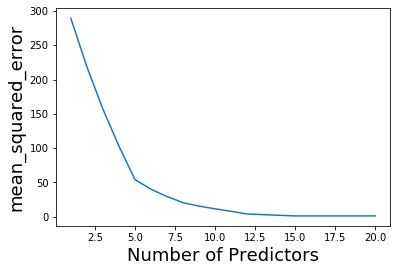

In [8]:
plt.plot(reg.index,reg['rss']/900)
plt.xlabel("Number of Predictors", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

**(d) Plot the test set MSE associated with the best model of each
size.**

In [9]:
from sklearn.metrics import mean_squared_error
mse_test_list = []
num_range = range(1,nvmax + 1)
for num_of_pre in num_range:
    reg_line = reg.loc[num_of_pre]
    y_predict = reg_line['params'][reg_line['X_columns']].dot(X_test[reg_line['X_columns']].T) + reg_line['params']['const']
    mse_test_list.append(mean_squared_error(y_test, y_predict))
mse_test = pd.DataFrame(mse_test_list,index = num_range)

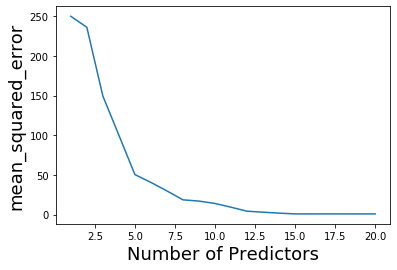

In [10]:
plt.plot(num_range,mse_test)
plt.xlabel("Number of Predictors", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

**(e) For which model size does the test set MSE take on its minimum
value? Comment on your results. If it takes on its minimum value
for a model containing only an intercept or a model containing
all of the features, then play around with the way that you are
generating the data in (a) until you come up with a scenario in
which the test set MSE is minimized for an intermediate model
size.**

In [11]:
mse_test.idxmin()

0    16
dtype: int64

与原始模型15个特征值有所差距，主要为eps影响

**(f) How does the model at which the test set MSE is minimized
compare to the true model used to generate the data? Comment
on the coefficient values.**

In [12]:
belta

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0,8,3,0,4,2,7,8,8,0,3,1,1,2,0,1,2,0,8,0,2


In [13]:
reg_line = reg.loc[int(mse_test.idxmin())]
reg_line['params']

const   -0.052107
X1       8.049497
X2       2.985162
X4       3.959084
X5       1.960426
X6       7.004749
X7       7.950898
X8       8.025230
X9       0.075328
X10      2.980225
X11      1.000332
X12      0.920765
X13      2.083027
X15      1.014710
X16      2.025657
X18      7.957073
X20      2.034537
dtype: float64

与原始模型多了截距和X9，同时截距和X9的拟合系数比较小

**(g) Create a plot displaying
’ ?
p
j=1 (β j
−
ˆ
β r
j ) 2
for a range of values
of r, where
ˆ
β r
j
is the jth coefficient estimate for the best model
containing r coefficients. Comment on what you observe. How
does this compare to the test MSE plot from (d)?**

In [14]:
belta_rss_list = []
for num_of_pre in num_range:
    reg_line = reg.loc[num_of_pre]
    belta_rss_list.append(np.sqrt(np.square(belta[reg_line['X_columns']] - reg_line['params'][reg_line['X_columns']]).sum(axis = 1)))
belta_rss = pd.DataFrame(belta_rss_list,index = num_range)

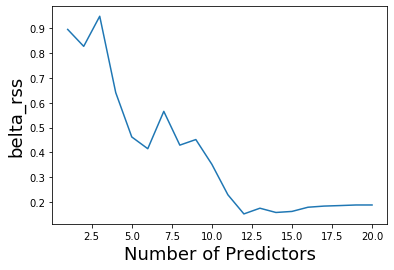

In [15]:
plt.plot(num_range,belta_rss)
plt.xlabel("Number of Predictors", fontsize=18)
plt.ylabel("belta_rss", fontsize=18)
plt.show()

In [16]:
belta_rss.idxmin()

0    12
dtype: int64

与test-mse有一定区别，在12个特征值时最小